In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и сохранение ################################
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [2]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [20]:
n_epochs = 200
batch_size = 64
lr = 0.0002
#
b1 = 0.5
b2 = 0.999
#
latent_dim = 30
#
# n_classes = 10
# img_size = 28
# channels = 1
#
sample_interval = 25
#
# img_shape = (channels, img_size, img_size)


In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        def block(in_feat, out_feat, normalize=True): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            nn.Linear(512, 2),
            nn.Tanh()
        )
#         self.activations = nn.ModuleDict([
#                 ['lrelu', nn.LeakyReLU()],
#                 ['relu', nn.ReLU()]])

    def forward(self, z):
        point = self.model(z)
        point = point.view(point.size(0), 2)
        return point

In [5]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out

        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights)

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005)
        nn.init.uniform_(self.bias, -0.005, 0.005)

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )


    def forward(self, point):
        point_flat = point.view(point.size(0), -1)
        validity = self.model(point_flat)

        return validity

In [13]:
class Function_Dataset(Dataset):
    def __init__(self):
        x = torch.linspace(-100, 100, 1000)
        y = (torch.sin(x) / x) - (x / 10)
        self.data = torch.stack((x, y), -1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return self.data[item]

In [14]:
real_data = torch.utils.data.DataLoader(
    Function_Dataset(),
    batch_size=batch_size,
    shuffle=True,
)

In [32]:
dataiter = iter(real_data)
points = dataiter.next()

In [33]:
generator = Generator(latent_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

In [34]:
d_loss_history = []
g_loss_history = []

In [35]:
for epoch in range(n_epochs):
    for i, points in enumerate(real_data):

        batch_size = points.shape[0]
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_points = Variable(points.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()

        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

        gen_points = generator(z)

        validity = discriminator(gen_points)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_points)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_points.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i

        if batches_done % sample_interval == 0:
            plt.clf()

            display.clear_output(wait=False)
           #print(gen_points)
            #print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) )


            #display.display(plt.gcf())

            d_loss_history.append(d_loss.detach())
            g_loss_history.append(g_loss.detach())

<Figure size 432x288 with 0 Axes>

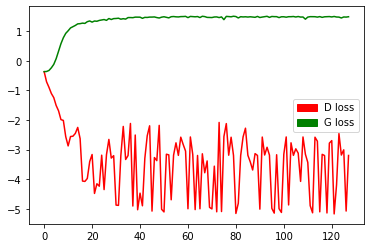

In [36]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')


plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
plt.legend(handles=[red_patch, green_patch])
plt.show()

In [38]:
batch_size = 64
z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

gen_points_ = generator(z)